# Introduction

This notebook contains code to explore a simple classification problem: distinguishing user-input numbers between 0-9.

The respective machine learning model will be created using tensorflow and the data is provided from the [MNIST data set](https://www.tensorflow.org/datasets/catalog/mnist).

## Setup

In [26]:
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt

## Get MNIST input data

The data is saved in an tf.data.Dataset instance, see https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [2]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [3]:
lookup_index = 4

for images, labels in ds_train.take(lookup_index):  # only take first element of dataset
    lookup_index -= 1
    if lookup_index == 0:
        print(f"label: {labels}")
        plt.imshow(images[:,:,0], cmap="gray")
        break

label: 7


NameError: name 'plt' is not defined

## Pipe the data
Code in line with https://www.tensorflow.org/datasets/keras_example

In [4]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

In [5]:
# normalize data
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE) 

# cache data set to memory when iterating
ds_train = ds_train.cache()

# shuffle data
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)

# batch consecutive elements together
ds_train = ds_train.batch(128)

# enable prefetching. consecutive elements will be prepared to be processed if the previous is currently
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Create the model

The input images are in total 28 by 28 = 784 pixels large.

There are several different layers used:
- layers.Flatten: flattens the input image. Avoids that for each row (or column) a new layers.Dense is created.
- layers.Dense: usual DNN layer
- layers.BatchNormalization: normalizes the layers inputs, see https://en.wikipedia.org/wiki/Batch_normalization. Improves convergence
- layers.Dropout: drop out (1/3) neurons per sample to prevent unwanted patterns based on noise on contrary to general patterns

In [92]:
model = tf.keras.models.Sequential([
    layers.Conv2D(kernel_size=3, filters=1, input_shape=(28, 28, 1), activation='relu', padding='same'),
#     layers.Conv2D(2, 3, activation='relu', input_shape=(28, 28)),
    layers.Flatten(input_shape=(28, 28, 1)),
#     layers.Dense(172, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(64, activation='relu'),
    layers.Dense(10),
#     layers.Softmax()
])

model.compile(
    # use established Adam algorithm for SGD
    optimizer=tf.keras.optimizers.Adam(0.001),
    
    # use a crossentropy function for the loss evaluation
    # the loss evaluation is the function of labels and predictions to be minimized 
    
    # the crossentropy is defined as H = E_p(x) (log q(x)) with p(x) and q(x) prob. distributions
    # being the expectation value of log(q) when distributed with p, similarly the regular entropy
    # could be defined using E_p log p, see https://en.wikipedia.org/wiki/Cross_entropy
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # from_logits=True if previous layer is normalized
    
    # used for visualization, counts the correct predictions
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

## Train the model

In [93]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)


history = model.fit(
    ds_train,
    epochs=100,
    validation_data=ds_test,
    callbacks=[early_stopping],
)

Epoch 1/100
469/469 [==============================] - 6s 11ms/step - loss: 0.5588 - sparse_categorical_accuracy: 0.8487 - val_loss: 0.3026 - val_sparse_categorical_accuracy: 0.9128
Epoch 2/100
469/469 [==============================] - 5s 11ms/step - loss: 0.3053 - sparse_categorical_accuracy: 0.9123 - val_loss: 0.2779 - val_sparse_categorical_accuracy: 0.9189
Epoch 3/100
469/469 [==============================] - 5s 11ms/step - loss: 0.2874 - sparse_categorical_accuracy: 0.9186 - val_loss: 0.2697 - val_sparse_categorical_accuracy: 0.9228
Epoch 4/100
469/469 [==============================] - 5s 11ms/step - loss: 0.2802 - sparse_categorical_accuracy: 0.9218 - val_loss: 0.2745 - val_sparse_categorical_accuracy: 0.9218
Epoch 5/100
469/469 [==============================] - 5s 11ms/step - loss: 0.2751 - sparse_categorical_accuracy: 0.9232 - val_loss: 0.2821 - val_sparse_categorical_accuracy: 0.9198
Epoch 6/100
469/469 [==============================] - 5s 11ms/step - loss: 0.2713 - spars

## Visualization
Visualize the training progress

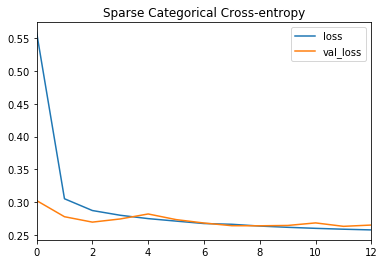

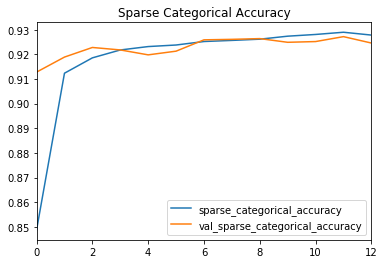

In [94]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Sparse Categorical Cross-entropy")
history_df.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(title="Sparse Categorical Accuracy")

[[ -2.120843   -12.529961     0.15902136   7.4359035  -17.143381
   -2.1011841   -9.219476    -3.402289    -4.0232434  -13.735132  ]]
prediction: 3


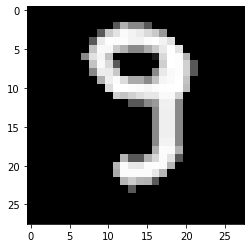

In [95]:
import numpy as np
import PIL

img = PIL.Image.open("tf_classification_user.png").convert("L")
imgarr = np.array(img).reshape((1,28,28,1))
imgarr = imgarr / np.max(imgarr)
# print(imgarr)
print(model.predict(imgarr))
print(f"prediction: {np.argmax(model(imgarr))}")
plt.imshow(imgarr[0,:,:,0], cmap="gray")